In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
gpm = xr.open_mfdataset('../2005/*')

In [3]:
imd = xr.open_dataset("_Clim_Pred_LRF_New_RF25_IMD0p252005.nc")

### Creating a function to correct timestamps of GPM data and to mask the data w.r.t IMD data
##### Also the coordinates of IMD data has been renamed to short and lower form, i.e., TIME --> time, LONGITUDE --> lon, and LATITUDE --> lat. 

In [4]:
def masked(gpm,imd):
    '''
    da1: data array to be masked
    da2: maksed dataarray
    returns: masked gpm dataarray
    '''
    gpm1 = gpm.copy()
    gpm1 = gpm1.transpose("time","lat","lon")
    
    imd1 = imd.copy()
    imd1 = imd1.rename({'TIME':'time',"LATITUDE":'lat',"LONGITUDE":'lon'})
    
    gpm1 = gpm1.sel(lat = slice(imd1.lat.min(),imd1.lat.max()),
            lon = slice(imd1.lon.min(),imd1.lon.max()))
    stdTime = gpm1.indexes['time'].to_datetimeindex()
    gpm1['time'] = stdTime
    gpi = gpm1.interp_like(imd1,method='nearest')
    gp = np.ma.array(gpi, mask=np.isnan(imd1))
    gpp = xr.DataArray(gp,coords=gpi.coords)
    return gpp,imd1

## Calling Function

In [5]:
gpm_new,imd_new = masked(gpm.precipitationCal,imd.RAINFALL)

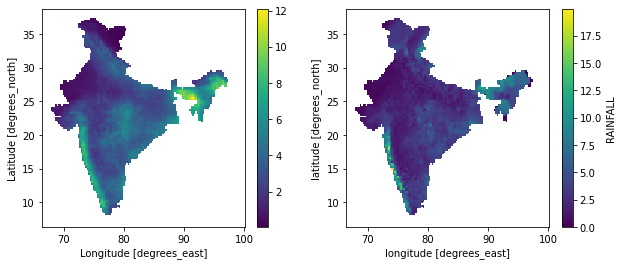

In [6]:
fig = plt.figure(figsize=[10,4])
ax = plt.subplot(121)
gpm_new.mean("time").plot()
ax = plt.subplot(122)
imd_new.mean("time").plot()

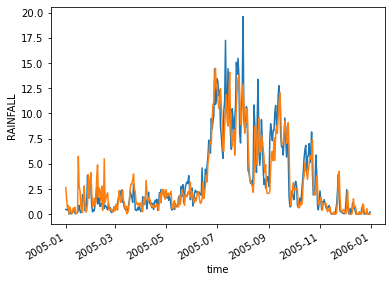

In [7]:
gpm_new.mean(["lat","lon"]).plot()
imd_new.mean(["lat","lon"]).plot()

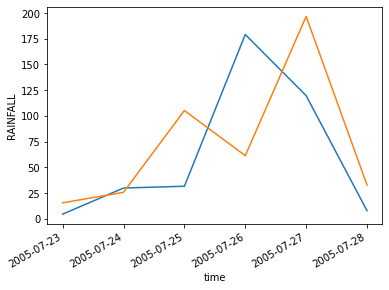

In [93]:
gpm_new.sel(time=slice('2005-07-23','2005-07-28'),lat=slice(17,20),lon=slice(71,73)).mean(["lon","lat"]).plot()
imd_new.sel(time=slice('2005-07-23','2005-07-28'),lat=slice(17,20),lon=slice(71,73)).mean(["lon","lat"]).plot()

In [49]:
correlation = xr.corr(gpm_new.mean(["lat","lon"]),imd_new.mean(["lat","lon"]))
print(correlation.values)

0.9064223612416591


In [51]:
bias = gpm_new.mean().values-imd_new.mean().values
print(bias)

0.08560181


In [69]:
import seaborn as sns

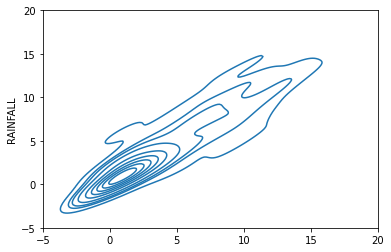

In [84]:
sns.kdeplot(gpm_new.mean(["lat","lon"]),imd_new.mean(["lat","lon"]))
plt.xlim(-5,20)
plt.ylim(-5,20)
plt.show()

<AxesSubplot:>

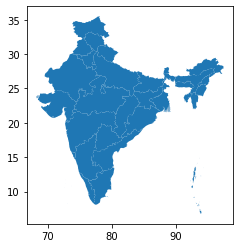

In [182]:
india = gpd.read_file('IND_adm1.shp')
india.plot()

<AxesSubplot:>

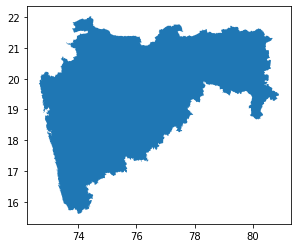

In [183]:
india[india['NAME_1']=='Maharashtra'].plot()

In [184]:
maha = india[india['NAME_1']=='Maharashtra']

In [185]:
from shapely.geometry import mapping

In [238]:
gpm_2 = gpm_new.rio.write_crs("epsg:4326")

In [240]:
maharain = gpm_2.rio.clip(maha.geometry.apply(mapping),maha.crs)

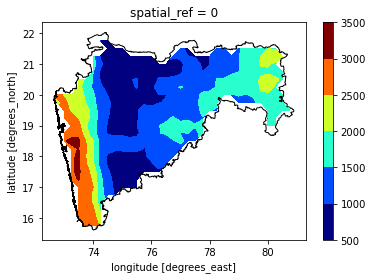

In [253]:
ax = plt.subplot()
maharain.sum("time").where(maharain.sum("time")>0).plot.contourf(cmap='jet')
maha.plot(ax = ax,ec = 'k',fc='none')
plt.show()

In [255]:
import pyart

In [256]:
grid = pyart.io.read_grid("../radar_mum/output/grid_MUM150615000342.nc")

In [258]:
grid.fields.keys()

dict_keys(['REF', 'VEL', 'WIDTH', 'ROI'])

In [259]:
xg = grid.to_xarray()

In [278]:
xg.reindex({'z'})

In [321]:
ds = xr.Dataset(
    {
        "REF":(["time", "z", "lat", "lon"], xg.REF.values,),
        "VELH":(["time", "z", "lat", "lon"], xg.VEL.values,),
    },
    coords={
        "z" :(['z'], xg.z.values),
        "lon" :(["lon"], xg.lon.values),
        "lat" :(["lat"], xg.lat.values),
        "time" :(["time"], xg.time.values),
    }
)

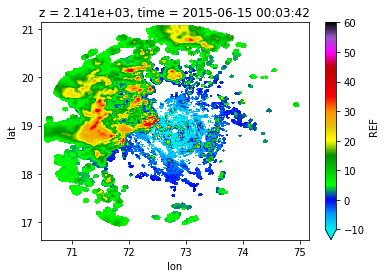

In [338]:
ds['REF'][0,4].plot(cmap='pyart_NWSRef',vmin=-10,vmax=60)

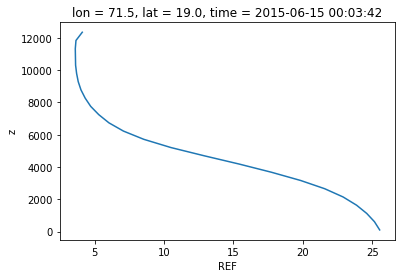

In [344]:
ds["REF"][0].sel(lat=19,lon=71.5,method='nearest').plot(y='z')